# Task 1: Data Preprocessing and Exploratory Data Analysis

## Objective
Load, clean, and understand the data to prepare it for modeling.

## Steps
1. Load Data
2. Data Cleaning (Types, Missing Values, Outliers)
3. EDA (Closing Prices, Daily % Change, Rolling Stats)
4. Stationarity Test (ADF)
5. Risk Metrics (VaR, Sharpe Ratio)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
import os

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
data = {}

for ticker in tickers:
    file_path = os.path.join('../data/raw', f'{ticker}.csv')
    if os.path.exists(file_path):
        # YFinance CSV has 3 header rows. Row 0: "Price,Close...", Row 1: "Ticker,TSLA...", Row 2: "Date,,..."
        # We read with header=[0, 1, 2] to capture all, and index_col=0 for Date.
        df = pd.read_csv(file_path, header=[0, 1, 2], index_col=0, parse_dates=True)
        
        # Flatten columns if multi-index. Level 0 contains 'Close', 'Open', etc.
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
            
        data[ticker] = df
        print(f"Loaded {ticker} data: {df.shape}")
    else:
        print(f"File for {ticker} not found.")

Loaded TSLA data: (2775, 5)
Loaded BND data: (2775, 5)
Loaded SPY data: (2775, 5)


## 2. Data Cleaning

In [3]:
for ticker, df in data.items():
    print(f"\n--- {ticker} Info ---")
    print(df.info())
    print("Missing Values:")
    print(df.isnull().sum())
    
    # Forward fill missing values if any
    if df.isnull().sum().sum() > 0:
        df.fillna(method='ffill', inplace=True)
        # Backward fill just in case first row is NaN
        df.fillna(method='bfill', inplace=True)
        print("Missing values handled.")


--- TSLA Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2775 entries, 2015-01-02 to 2026-01-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2775 non-null   float64
 1   High    2775 non-null   float64
 2   Low     2775 non-null   float64
 3   Open    2775 non-null   float64
 4   Volume  2775 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 130.1 KB
None
Missing Values:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

--- BND Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2775 entries, 2015-01-02 to 2026-01-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2775 non-null   float64
 1   High    2775 non-null   float64
 2   Low     2775 non-null   float64
 3   Open    2775 non-null   float64
 4   Volume  2775 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 13

## 3. Exploratory Data Analysis (EDA)

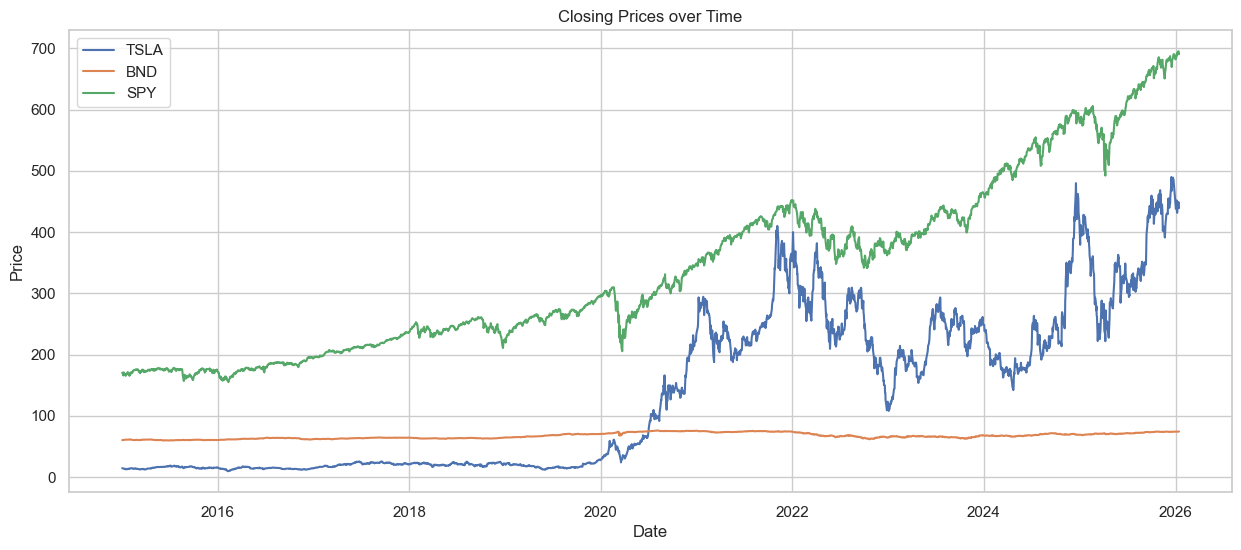

In [4]:
# Plot Closing Prices
plt.figure(figsize=(15, 6))
for ticker, df in data.items():
    plt.plot(df.index, df['Close'], label=ticker)
plt.title('Closing Prices over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

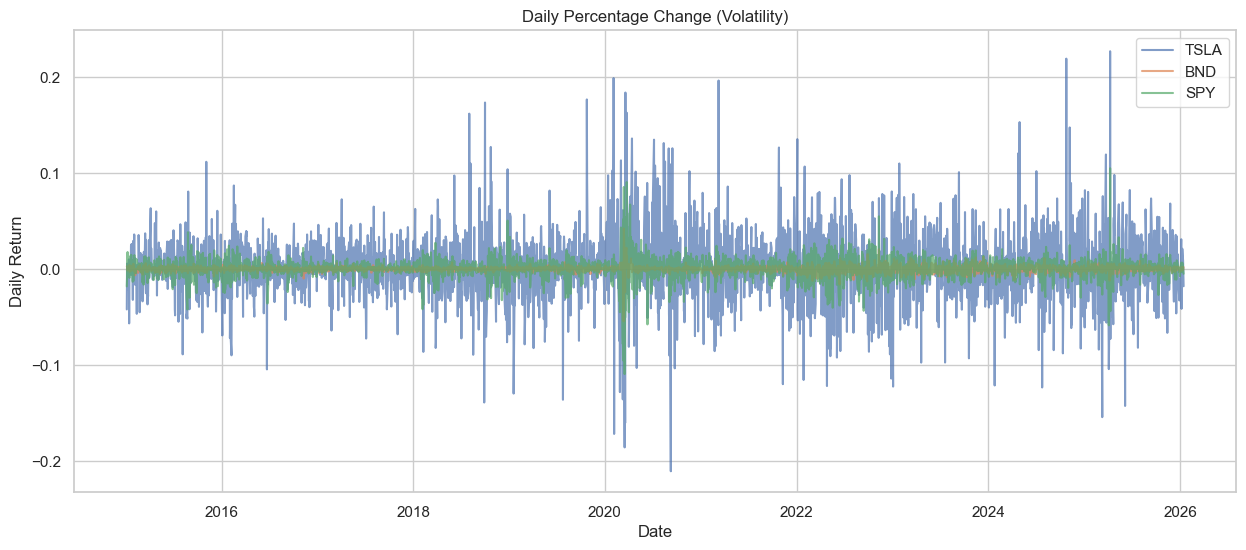

In [5]:
# Daily Percentage Change
plt.figure(figsize=(15, 6))
for ticker, df in data.items():
    df['Daily Return'] = df['Close'].pct_change()
    plt.plot(df.index, df['Daily Return'], label=ticker, alpha=0.7)
plt.title('Daily Percentage Change (Volatility)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

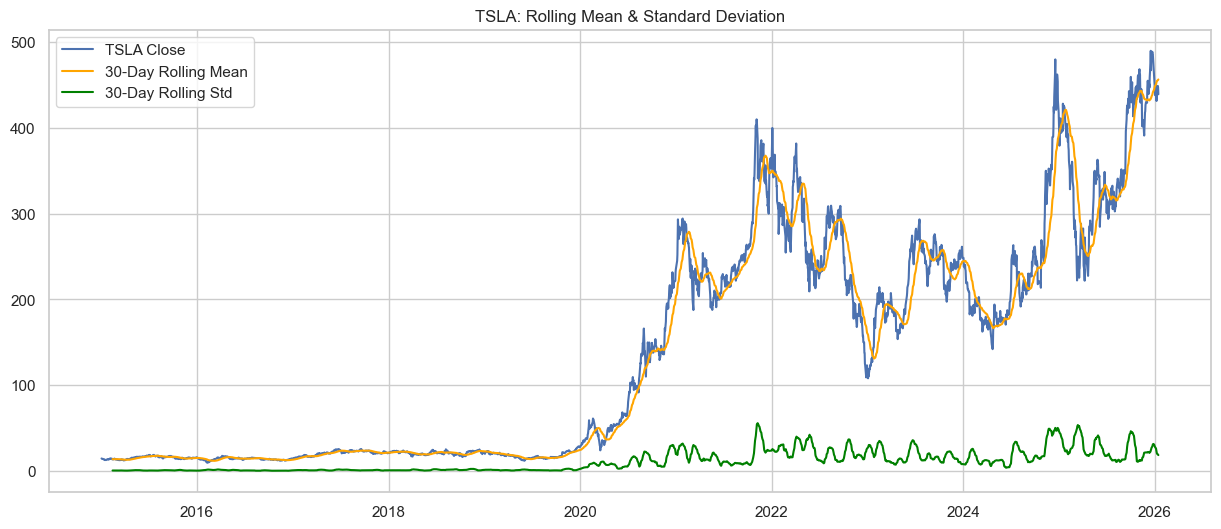

In [6]:
# Rolling Statistics (TSLA)
tsla = data['TSLA']
rolling_mean = tsla['Close'].rolling(window=30).mean()
rolling_std = tsla['Close'].rolling(window=30).std()

plt.figure(figsize=(15, 6))
plt.plot(tsla.index, tsla['Close'], label='TSLA Close')
plt.plot(tsla.index, rolling_mean, label='30-Day Rolling Mean', color='orange')
plt.plot(tsla.index, rolling_std, label='30-Day Rolling Std', color='green')
plt.title('TSLA: Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

### Outlier Detection

In [7]:
# Use Z-score on Daily Returns to find outliers
from scipy import stats

tsla_returns = tsla['Daily Return'].dropna()
z_scores = np.abs(stats.zscore(tsla_returns))
outliers = tsla_returns[z_scores > 3]

print(f"Number of outliers detected for TSLA: {len(outliers)}")
print("Top 5 Outliers (high/low returns):")
print(outliers.sort_values(key=abs, ascending=False).head())

Number of outliers detected for TSLA: 44
Top 5 Outliers (high/low returns):
2025-04-09    0.226900
2024-10-24    0.219190
2020-09-08   -0.210628
2020-02-03    0.198949
2021-03-09    0.196412
Name: Daily Return, dtype: float64


## 4. Stationarity Test (ADF)

In [8]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Result: The series is Stationary")
    else:
        print("Result: The series is Non-Stationary")

print("--- TSLA Closing Price AD Full Test ---")
adf_test(tsla['Close'])

print("\n--- TSLA Daily Returns AD Full Test ---")
adf_test(tsla['Daily Return'])

--- TSLA Closing Price AD Full Test ---
ADF Statistic: -0.7801569882105649
p-value: 0.8248814297221108
Critical Values:
	1%: -3.4327336210581345
	5%: -2.8625931125961683
	10%: -2.567330605587204
Result: The series is Non-Stationary

--- TSLA Daily Returns AD Full Test ---


ADF Statistic: -53.01961854424363
p-value: 0.0
Critical Values:
	1%: -3.4327103908048398
	5%: -2.862582853253982
	10%: -2.567325143520494
Result: The series is Stationary


## 5. Risk Metrics

In [9]:
# Value at Risk (VaR) at 95% confidence level
var_95 = np.percentile(tsla_returns, 5)
print(f"VaR at 95% confidence: {var_95:.4f}")

# Sharpe Ratio (assuming risk-free rate ~0 for simplicity or use actual)
rf_rate = 0.0
sharpe_ratio = (tsla_returns.mean() - rf_rate) / tsla_returns.std() * np.sqrt(252) # Annualized
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

VaR at 95% confidence: -0.0525
Sharpe Ratio: 0.8232


## 6. Save Processed Data

In [10]:
output_dir = '../data/processed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for ticker, df in data.items():
    file_path = os.path.join(output_dir, f'{ticker}_processed.csv')
    df.to_csv(file_path)
    print(f"Saved processed data for {ticker} to {file_path}")

Saved processed data for TSLA to ../data/processed\TSLA_processed.csv
Saved processed data for BND to ../data/processed\BND_processed.csv
Saved processed data for SPY to ../data/processed\SPY_processed.csv
